# CSC 180 FINAL PROJECT Car accident Severity detection
Professor Haiquan Chen
11/25/2024 <br>
Jose Avalos <br>
Jose Vasquez <br>
Jomel Sotelo <br>
Mitchell Kouiyoth <br>
Car accident severity detection has the potential to significantly improve the efficiency of emergency response services, helping to save lives by providing timely and effective resource allocation. This paper addresses the problem of predicting the severity level of car accidents using the US Traffic Accidents dataset, which contains detailed information on accidents across the United States from 2016 to 2020. We propose using deep learning models to classify accidents into different severity levels, leveraging both FCNN and CNN models

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-2020-traffic-accidents/acc_17.csv
/kaggle/input/us-2020-traffic-accidents/acc_20.csv
/kaggle/input/us-2020-traffic-accidents/pers_16.csv
/kaggle/input/us-2020-traffic-accidents/acc_19.csv
/kaggle/input/us-2020-traffic-accidents/veh_19.csv
/kaggle/input/us-2020-traffic-accidents/veh_20.csv
/kaggle/input/us-2020-traffic-accidents/pers_17.csv
/kaggle/input/us-2020-traffic-accidents/veh_16.csv
/kaggle/input/us-2020-traffic-accidents/pers_18.csv
/kaggle/input/us-2020-traffic-accidents/pers_20.csv
/kaggle/input/us-2020-traffic-accidents/veh_17.csv
/kaggle/input/us-2020-traffic-accidents/acc_16.csv
/kaggle/input/us-2020-traffic-accidents/pers_19.csv
/kaggle/input/us-2020-traffic-accidents/acc_18.csv
/kaggle/input/us-2020-traffic-accidents/veh_18.csv


# Useful functions from class

In [4]:
import pandas as pd
import numpy as np
from collections.abc import Sequence
import matplotlib.pyplot as plt
import shutil
import os
import json
import csv
import glob
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn import preprocessing
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Embedding, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
        # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [8]:
df= pd.read_csv('/kaggle/input/us-2020-traffic-accidents/acc_16.csv')
df1= pd.read_csv('/kaggle/input/us-2020-traffic-accidents/pers_16.csv')
df2= pd.read_csv('/kaggle/input/us-2020-traffic-accidents/veh_16.csv')

/tmp/ipykernel_30/1532443961.py:3: DtypeWarning: Columns (23,24,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df2= pd.read_csv('/kaggle/input/us-2020-traffic-accidents/veh_16.csv')


In [6]:
df

,CASENUM,PSU,PJ,STRATUM,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERMVIT,PERNOTMVIT,...,LGTCON_IM,WEATHR_IM,MAXSEV_IM,NO_INJ_IM,ALCHL_IM,URBANICITY,REGION,PSUSTRAT,PSU_VAR,WEIGHT
0,201600014311,44,388,9,2,2,0,0,2,0,...,1,1,0,0,2,2,4,25,44,219.795475
1,201600014315,44,388,8,2,2,0,0,4,0,...,3,1,1,4,2,2,4,25,44,186.634758
2,201600014316,44,388,5,1,1,0,0,1,0,...,3,1,3,1,2,2,4,25,44,32.222550
3,201600014335,44,388,10,2,2,0,0,2,0,...,3,3,0,0,2,2,4,25,44,317.681532
4,201600014586,24,170,2,1,1,0,1,1,1,...,1,1,2,1,2,2,4,24,24,37.251626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46506,201600991753,41,163,7,2,2,0,0,4,0,...,1,1,0,0,2,1,4,22,41,301.125042
46507,201600991782,41,163,6,3,3,0,0,6,0,...,3,1,3,3,2,1,4,22,41,98.551521
46508,201600991811,41,163,10,2,2,0,0,3,0,...,3,1,0,0,2,1,4,22,41,357.694967
46509,201600991821,41,160,8,1,1,0,0,1,0,...,1,10,3,1,2,1,4,22,41,234.268106


In [1]:
df1

NameError: name 'df1' is not defined

In [9]:
df2

,CASENUM,VEH_NO,PSU,PJ,STRATUM,VE_FORMS,NUMOCCS,MONTH,HOUR,MINUTE,...,VEVENT_IM,PCRASH1_IM,MXVSEV_IM,NUMINJ_IM,V_ALCH_IM,URBANICITY,REGION,PSUSTRAT,PSU_VAR,WEIGHT
0,201600014311,1,44,388,9,2,1,1,12,33,...,12,15,0,0,2,2,4,25,44,219.795475
1,201600014311,2,44,388,9,2,1,1,12,33,...,12,1,0,0,2,2,4,25,44,219.795475
2,201600014315,1,44,388,8,2,1,1,19,32,...,12,11,1,1,2,2,4,25,44,186.634758
3,201600014315,2,44,388,8,2,3,1,19,32,...,12,1,1,3,2,2,4,25,44,186.634758
4,201600014316,1,44,388,5,1,1,1,6,20,...,1,1,3,1,2,2,4,25,44,32.222550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82144,201600991811,1,41,163,10,2,1,12,18,55,...,12,1,0,0,2,1,4,22,41,357.694967
82145,201600991811,2,41,163,10,2,2,12,18,55,...,12,2,0,0,2,1,4,22,41,357.694967
82146,201600991821,1,41,160,8,1,1,1,10,10,...,1,14,3,1,2,1,4,22,41,234.268106
82147,201600991832,1,41,160,6,2,2,1,11,32,...,12,2,0,0,2,1,4,22,41,98.551521


# DATA PREPROCESSING -Jose A

Extract

Go through a fodder containing all the csv files and pull only the columns of inetrestbased on correlation coefficient and various picks of categorical.d turn it into a dataframly

In [62]:
acc_cols = ['CASENUM','STRATUM','STRATUMNAME','WEIGHT', 'VE_TOTAL', 'VE_FORMS', 'MAXSEV_IM','HARM_EV', 'HARM_EVNAME', 
            'WEATHER','WEATHERNAME','LGT_COND', 'LGT_CONDNAME', 'ROAD_FNCNAME']

per_cols = ['CASENUM','STRATUM','STRATUMNAME','AGE', 'SEAT_POS_IM', 'EJECT_IM','SEX' 
            'SEXNAME','DRINKING', 'DRINKINGNAME','EJECTION','EJECTIONNAME','INJ_SEV', 'INJ_SEVNAME']

veh_cols = ['CASENUM','STRATUM','STRATUMNAME','WEIGHT', 'VEVENT_IM', 'MAX_VSEV', 'NUMINJ_IM','BODY_TYP',
            'BODY_TYPNAME','TOWED', 'TOWEDNAME','ROLLOVER', 'ROLLOVERNAME']

# acc_cols = ['CASENUM','STRATUM','STRATUMNAME','URBANICITY','URBANICITYNAME','VE_TOTAL','NUM_INJ','NUM_INJNAME','MONTH','MONTHNAME',
# 'YEAR','DAY_WEEK','DAY_WEEKNAME','HOUR','ALCOHOL','ALCOHOLNAME','MAX_SEV','MAX_SEVNAME','MAN_COL','MAN_COLNAME','LGT_COND','LGT_CONDNAME','WEATHER','WEATHERNAME']

# per_cols = ['CASENUM','STRATUM','STRATUMNAME','AGE','SEX','SEXNAME','PER_TYP',
# 'PER_TYPNAME','DRINKING','DRINKINGNAME','HOSPITAL','HOSPITALNAME','DRUGS','DRUGSNAME']

# veh_cols = ['CASENUM','STRATUM','STRATUMNAME','HIT_RUN','DEFORMED','DEFORMEDNAME','TOWED','TOWEDNAME','VSPD_LIM','VSPD_LIMNAME',
# 'VSURCOND','VSURCONDNAME']


accidents = []
persons = []
vehicles = []
total_dfs = {'accidents':accidents,'persons':persons,'vehicles':vehicles}

#for file in glob.glob(r'C:\Users\Caio\OneDrive\Desktop\ETL_US_ACCIDENTS\data\*.csv'):
for file in glob.glob(r'/kaggle/input/us-2020-traffic-accidents/*.csv'):
    
    filename = file.split('/')[-1].split('.')[0]
    
    if filename.startswith('acc'):
        dfname = filename
        print(f'Created Dataframe {dfname}')
        globals()[dfname] = pd.read_csv(file, encoding='cp1252', usecols=lambda c: c in set(acc_cols))
        accidents.append(globals()[dfname])
        
        
    elif filename.startswith('per'):
        dfname = filename
        print(f'Created Dataframe {dfname}')
        globals()[dfname] = pd.read_csv(file, encoding='cp1252', usecols=lambda c: c in set(per_cols))
        persons.append(globals()[dfname])
        
    else:
        dfname = filename
        print(f'Created Dataframe {dfname}')
        globals()[dfname] = pd.read_csv(file, encoding='cp1252', usecols=lambda c: c in set(veh_cols))
        vehicles.append(globals()[dfname])

Created Dataframe acc_17
Created Dataframe acc_20
Created Dataframe pers_16
Created Dataframe acc_19
Created Dataframe veh_19
Created Dataframe veh_20
Created Dataframe pers_17
Created Dataframe veh_16
Created Dataframe pers_18
Created Dataframe pers_20
Created Dataframe veh_17
Created Dataframe acc_16
Created Dataframe pers_19
Created Dataframe acc_18
Created Dataframe veh_18


In [63]:
print("Shape of df data: {}".format(acc_16.shape))
print("Shape of df data: {}".format(acc_17.shape))
print("Shape of df data: {}".format(acc_18.shape))
print("Shape of df data: {}".format(acc_19.shape))
print("Shape of df data: {}".format(acc_20.shape))

Shape of df data: (46511, 9)
Shape of df data: (54969, 9)
Shape of df data: (48443, 9)
Shape of df data: (54409, 13)
Shape of df data: (54745, 13)


In [64]:
print("Shape of df data: {}".format(pers_16.shape))
print("Shape of df data: {}".format(pers_17.shape))
print("Shape of df data: {}".format(pers_18.shape))
print("Shape of df data: {}".format(pers_19.shape))
print("Shape of df data: {}".format(pers_20.shape))

Shape of df data: (117759, 7)
Shape of df data: (138913, 7)
Shape of df data: (120230, 7)
Shape of df data: (135410, 11)
Shape of df data: (131962, 11)


In [65]:
print("Shape of df data: {}".format(veh_16.shape))
print("Shape of df data: {}".format(veh_17.shape))
print("Shape of df data: {}".format(veh_18.shape))
print("Shape of df data: {}".format(veh_19.shape))
print("Shape of df data: {}".format(veh_20.shape))

Shape of df data: (82149, 9)
Shape of df data: (97625, 9)
Shape of df data: (86105, 9)
Shape of df data: (96717, 13)
Shape of df data: (94718, 13)


In [66]:
veh_16

,CASENUM,STRATUM,BODY_TYP,ROLLOVER,TOWED,MAX_VSEV,VEVENT_IM,NUMINJ_IM,WEIGHT
0,201600014311,9,4,0,5,0,12,0,219.795475
1,201600014311,9,5,0,5,0,12,0,219.795475
2,201600014315,8,31,0,2,1,12,1,186.634758
3,201600014315,8,30,0,2,1,12,3,186.634758
4,201600014316,5,4,1,2,3,1,1,32.222550
...,...,...,...,...,...,...,...,...,...
82144,201600991811,10,14,0,2,0,12,0,357.694967
82145,201600991811,10,5,0,5,0,12,0,357.694967
82146,201600991821,8,14,9,2,3,1,1,234.268106
82147,201600991832,6,14,0,5,0,12,0,98.551521


In [67]:
veh_20

,CASENUM,STRATUM,STRATUMNAME,BODY_TYP,BODY_TYPNAME,ROLLOVER,ROLLOVERNAME,TOWED,TOWEDNAME,MAX_VSEV,VEVENT_IM,NUMINJ_IM,WEIGHT
0,202002121240,9,Stratum 9 - LMY PV No Injuries in Crash,4,"4-door sedan, hardtop",0,No Rollover,3,Towed But Not Due to Disabling Damage,0,12,0,161.358280
1,202002121240,9,Stratum 9 - LMY PV No Injuries in Crash,34,Light Pickup,0,No Rollover,3,Towed But Not Due to Disabling Damage,0,12,0,161.358280
2,202002121829,8,Stratum 8 - NLMY PV Minor Injury,4,"4-door sedan, hardtop",0,No Rollover,5,Not Towed,2,42,1,131.962215
3,202002121849,9,Stratum 9 - LMY PV No Injuries in Crash,9,Other or Unknown automobile type,0,No Rollover,5,Not Towed,9,12,0,165.957768
4,202002121849,9,Stratum 9 - LMY PV No Injuries in Crash,4,"4-door sedan, hardtop",0,No Rollover,5,Not Towed,0,12,0,165.957768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94713,202003020782,8,Stratum 8 - NLMY PV Minor Injury,34,Light Pickup,1,"Rollover, Tripped by Object/Vehicle",2,Towed Due to Disabling Damage,2,1,1,98.791248
94714,202003020795,10,Stratum 10 - Other,20,"Minivan (Chrysler Town and Country, Caravan, G...",0,No Rollover,2,Towed Due to Disabling Damage,0,12,0,168.228948
94715,202003020795,10,Stratum 10 - Other,34,Light Pickup,0,No Rollover,5,Not Towed,0,12,0,168.228948
94716,202003020807,7,Stratum 7 - M/H Truck or Bus,14,"Compact Utility (Utility Vehicle Categories ""S...",0,No Rollover,2,Towed Due to Disabling Damage,0,12,0,123.995192


# for numeric values, find specific columns that has less than correlation coefficient of less than .05
use this to figure out which numeric column to keep
Mitchell K

In [68]:
correlation_list = veh_16[veh_16.columns[:]].corr()['STRATUM']

correlation_list = [column for column in correlation_list.index if correlation_list[column] < 0.05]
print(correlation_list)

['CASENUM', 'BODY_TYP', 'ROLLOVER', 'MAX_VSEV', 'NUMINJ_IM']


In [69]:
correlation_list = acc_16[acc_16.columns[:]].corr()['STRATUM']

correlation_list = [column for column in correlation_list.index if correlation_list[column] < 0.05]
print(correlation_list)

['CASENUM', 'LGT_COND', 'WEATHER', 'MAXSEV_IM']


In [70]:
correlation_list = pers_16[pers_16.columns[:]].corr()['STRATUM']

correlation_list = [column for column in correlation_list.index if correlation_list[column] < 0.05]
print(correlation_list)

['CASENUM', 'AGE', 'INJ_SEV', 'EJECTION', 'DRINKING', 'EJECT_IM']


# Standardize all dataframes by:
Choosing the 2020 file as the standard then find what columns are missing from each file compared to the 2020 version,add the missing columns -Jomel Ss

In [71]:
def find_missing_columns(dfs):

    all_columns = set()
    for df in dfs:
        all_columns.update(df.columns)
    
    common_columns = set(dfs[0].columns)
    for df in dfs[1:]:
        common_columns.intersection_update(df.columns)
    
    cols_to_add = list(all_columns - common_columns)
    
    return cols_to_add

cols_missing = {}
for key, dflist in total_dfs.items():
    missing_cols = find_missing_columns(dflist)
    cols_missing[key] = missing_cols

In [72]:
for df in accidents:
    for col in cols_missing['accidents']:

        namecol = col
        numcol = col[:-4]

        mapping = acc_20[[namecol, numcol]].drop_duplicates()
        dic = dict(zip(mapping[numcol], mapping[namecol]))

        df[namecol] = df[numcol].map(dic)
        
for df in persons:
    for col in cols_missing['persons']:
        namecol = col
        numcol = col[:-4]

        mapping = pers_20[[namecol, numcol]].drop_duplicates()
        dic = dict(zip(mapping[numcol], mapping[namecol]))

        df[namecol] = df[numcol].map(dic)
    
    
for df in vehicles:
    for col in cols_missing['vehicles']:
        namecol = col
        numcol = col[:-4]

        mapping = veh_20[[namecol, numcol]].drop_duplicates()
        dic = dict(zip(mapping[numcol], mapping[namecol])) 

        df[namecol] = df[numcol].map(dic)

In [73]:
# Concatenate the lists into single DataFrames for each type
accidents_df = pd.concat(accidents, ignore_index=True)
persons_df = pd.concat(persons, ignore_index=True)
vehicles_df = pd.concat(vehicles, ignore_index=True)

In [74]:
accidents_df

,CASENUM,STRATUM,VE_TOTAL,VE_FORMS,HARM_EV,LGT_COND,WEATHER,MAXSEV_IM,WEIGHT,LGT_CONDNAME,STRATUMNAME,HARM_EVNAME,WEATHERNAME
0,201700000117,3,2,2,12,1,1,2,29.270311,Daylight,Stratum 3 - Motorcycle Any Injury,Motor Vehicle In-Transport,Clear
1,201700000119,6,3,3,12,1,1,1,62.100147,Daylight,Stratum 6 - LMY PV Minor Injury,Motor Vehicle In-Transport,Clear
2,201700000124,9,2,2,12,1,1,0,181.168210,Daylight,Stratum 9 - LMY PV No Injuries in Crash,Motor Vehicle In-Transport,Clear
3,201700000144,3,2,2,12,2,10,3,27.870445,Dark - Not Lighted,Stratum 3 - Motorcycle Any Injury,Motor Vehicle In-Transport,Cloudy
4,201700000154,10,2,2,12,3,10,0,236.352198,Dark - Lighted,Stratum 10 - Other,Motor Vehicle In-Transport,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259072,201801402590,9,2,2,12,1,1,0,204.580798,Daylight,Stratum 9 - LMY PV No Injuries in Crash,Motor Vehicle In-Transport,Clear
259073,201801402620,8,2,2,12,1,2,2,194.662175,Daylight,Stratum 8 - NLMY PV Minor Injury,Motor Vehicle In-Transport,Rain
259074,201801402628,6,2,2,12,3,98,1,82.623031,Dark - Lighted,Stratum 6 - LMY PV Minor Injury,Motor Vehicle In-Transport,Not Reported
259075,201801402629,4,2,2,12,3,1,3,16.071732,Dark - Lighted,Stratum 4 - LMY PV Serious Injury,Motor Vehicle In-Transport,Clear


In [75]:
persons_df

,CASENUM,STRATUM,AGE,INJ_SEV,EJECTION,DRINKING,EJECT_IM,STRATUMNAME,DRINKINGNAME,INJ_SEVNAME,EJECTIONNAME
0,201600014311,9,72,0,0,0,0,Stratum 9 - LMY PV No Injuries in Crash,No (Alcohol Not Involved),No Apparent Injury (O),Not Ejected
1,201600014311,9,31,0,0,0,0,Stratum 9 - LMY PV No Injuries in Crash,No (Alcohol Not Involved),No Apparent Injury (O),Not Ejected
2,201600014315,8,17,1,0,0,0,Stratum 8 - NLMY PV Minor Injury,No (Alcohol Not Involved),Possible Injury (C),Not Ejected
3,201600014315,8,18,1,0,0,0,Stratum 8 - NLMY PV Minor Injury,No (Alcohol Not Involved),Possible Injury (C),Not Ejected
4,201600014315,8,18,1,0,0,0,Stratum 8 - NLMY PV Minor Injury,No (Alcohol Not Involved),Possible Injury (C),Not Ejected
...,...,...,...,...,...,...,...,...,...,...,...
644269,201902285953,9,69,0,0,8,0,Stratum 9 - LMY PV No Injuries in Crash,Not Reported,No Apparent Injury (O),Not Ejected
644270,201902285953,9,44,0,0,8,0,Stratum 9 - LMY PV No Injuries in Crash,Not Reported,No Apparent Injury (O),Not Ejected
644271,201902285965,6,56,2,0,8,0,Stratum 6 - LMY PV Minor Injury,Not Reported,Suspected Minor Injury (B),Not Ejected
644272,201902285965,6,42,0,0,8,0,Stratum 6 - LMY PV Minor Injury,Not Reported,No Apparent Injury (O),Not Ejected


In [76]:
vehicles_df

,CASENUM,STRATUM,STRATUMNAME,BODY_TYP,BODY_TYPNAME,ROLLOVER,ROLLOVERNAME,TOWED,TOWEDNAME,MAX_VSEV,WEIGHT,VEVENT_IM,NUMINJ_IM
0,201901174219,10,Stratum 10 - Other,34,Light Pickup,1,"Rollover, Tripped by Object/Vehicle",2,Towed Due to Disabling Damage,0,203.665120,1,0
1,201901176655,6,Stratum 6 - LMY PV Minor Injury,4,"4-door sedan, hardtop",0,No Rollover,3,Towed But Not Due to Disabling Damage,1,59.073459,12,1
2,201901176655,6,Stratum 6 - LMY PV Minor Injury,14,"Compact Utility (Utility Vehicle Categories ""S...",0,No Rollover,8,Not Reported,1,59.073459,12,1
3,201901176667,8,Stratum 8 - NLMY PV Minor Injury,14,"Compact Utility (Utility Vehicle Categories ""S...",0,No Rollover,2,Towed Due to Disabling Damage,2,133.664224,12,1
4,201901176667,8,Stratum 8 - NLMY PV Minor Injury,34,Light Pickup,0,No Rollover,2,Towed Due to Disabling Damage,1,133.664224,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
457309,201801402628,6,Stratum 6 - LMY PV Minor Injury,9,Other or Unknown automobile type,0,No Rollover,2,Towed Due to Disabling Damage,1,82.623031,12,1
457310,201801402628,6,Stratum 6 - LMY PV Minor Injury,9,Other or Unknown automobile type,0,No Rollover,2,Towed Due to Disabling Damage,1,82.623031,12,1
457311,201801402629,4,Stratum 4 - LMY PV Serious Injury,9,Other or Unknown automobile type,0,No Rollover,3,Towed But Not Due to Disabling Damage,1,16.071732,12,1
457312,201801402629,4,Stratum 4 - LMY PV Serious Injury,20,"Minivan (Chrysler Town and Country, Caravan, G...",0,No Rollover,2,Towed Due to Disabling Damage,3,16.071732,12,1


# Merge the 12 different files by CASENUM - Jose V

In [77]:
# Merge while keeping STRATUM consistent
accidents_persons_merged = pd.merge(accidents_df, persons_df, on=['CASENUM', 'STRATUM','STRATUMNAME'], how='outer')
final_df = pd.merge(accidents_persons_merged, vehicles_df, on=['CASENUM', 'STRATUM','STRATUMNAME'], how='outer')

In [78]:
final_df.shape

(1275881, 31)

# Drop any records with missing rows and duplicates

In [79]:
print("Number of rows:", len(final_df.index))
final_df.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(final_df.index))

Number of rows: 1275881
Number of rows after drop of duplicates: 1180742


In [80]:
final_df.replace('-',np.nan,inplace=True)
final_df.dropna(inplace=True)

In [81]:
print("Number of rows after drop",final_df.shape)

Number of rows after drop (1155221, 31)


In [82]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1155221 entries, 0 to 1275880
Data columns (total 31 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   CASENUM       1155221 non-null  int64  
 1   STRATUM       1155221 non-null  int64  
 2   VE_TOTAL      1155221 non-null  int64  
 3   VE_FORMS      1155221 non-null  int64  
 4   HARM_EV       1155221 non-null  int64  
 5   LGT_COND      1155221 non-null  int64  
 6   WEATHER       1155221 non-null  int64  
 7   MAXSEV_IM     1155221 non-null  int64  
 8   WEIGHT_x      1155221 non-null  float64
 9   LGT_CONDNAME  1155221 non-null  object 
 10  STRATUMNAME   1155221 non-null  object 
 11  HARM_EVNAME   1155221 non-null  object 
 12  WEATHERNAME   1155221 non-null  object 
 13  AGE           1155221 non-null  float64
 14  INJ_SEV       1155221 non-null  float64
 15  EJECTION      1155221 non-null  float64
 16  DRINKING      1155221 non-null  float64
 17  EJECT_IM      1155221 non-null  

In [83]:
final_df.rename(columns={'WEIGHT_x': 'WEIGHT'}, inplace=True)
final_df.drop(columns=['WEIGHT_y', 'STRATUMNAME'], inplace=True)

In [84]:
final_df

,CASENUM,STRATUM,VE_TOTAL,VE_FORMS,HARM_EV,LGT_COND,WEATHER,MAXSEV_IM,WEIGHT,LGT_CONDNAME,...,EJECTIONNAME,BODY_TYP,BODY_TYPNAME,ROLLOVER,ROLLOVERNAME,TOWED,TOWEDNAME,MAX_VSEV,VEVENT_IM,NUMINJ_IM
0,201600014311,9,2,2,12,1,1,0,219.795475,Daylight,...,Not Ejected,4,"4-door sedan, hardtop",0,No Rollover,5,Not Towed,0,12,0
1,201600014311,9,2,2,12,1,1,0,219.795475,Daylight,...,Not Ejected,5,5-door/4-door hatchback,0,No Rollover,5,Not Towed,0,12,0
2,201600014311,9,2,2,12,1,1,0,219.795475,Daylight,...,Not Ejected,4,"4-door sedan, hardtop",0,No Rollover,5,Not Towed,0,12,0
3,201600014311,9,2,2,12,1,1,0,219.795475,Daylight,...,Not Ejected,5,5-door/4-door hatchback,0,No Rollover,5,Not Towed,0,12,0
12,201600014316,5,1,1,43,3,1,3,32.222550,Dark - Lighted,...,Totally Ejected,4,"4-door sedan, hardtop",1,"Rollover, Tripped by Object/Vehicle",2,Towed Due to Disabling Damage,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275874,202003020807,7,2,2,12,8,1,0,123.995192,Not Reported,...,Not Ejected,61,Single-unit straight truck or Cab-Chassis (GVW...,0,No Rollover,5,Not Towed,0,12,0
1275875,202003020807,7,2,2,12,8,1,0,123.995192,Not Reported,...,Not Ejected,14,"Compact Utility (Utility Vehicle Categories ""S...",0,No Rollover,2,Towed Due to Disabling Damage,0,12,0
1275876,202003020807,7,2,2,12,8,1,0,123.995192,Not Reported,...,Not Ejected,61,Single-unit straight truck or Cab-Chassis (GVW...,0,No Rollover,5,Not Towed,0,12,0
1275879,202003020807,7,2,2,12,8,1,0,123.995192,Not Reported,...,Not Ejected,14,"Compact Utility (Utility Vehicle Categories ""S...",0,No Rollover,2,Towed Due to Disabling Damage,0,12,0


# UNDERSAMPLING - Mitchell K

visual the difference between each STRATUM categories

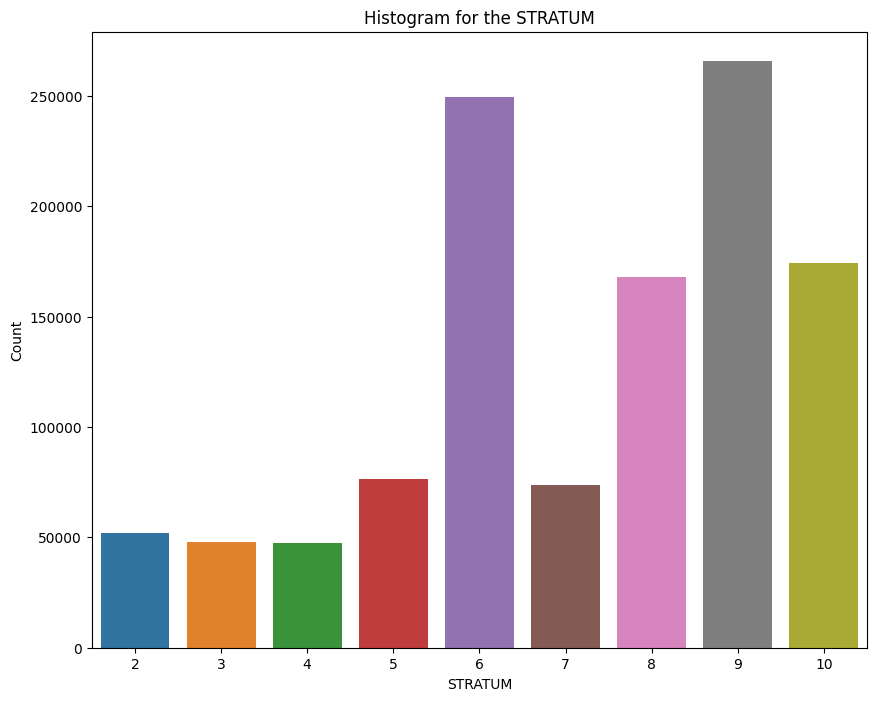

In [85]:
# Inspect your target variable distribution
X = final_df.copy()
severity_counts = X["STRATUM"].value_counts()

# Visualize the distribution
plt.figure(figsize=(10, 8))
plt.title("Histogram for the STRATUM")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("STRATUM")
plt.ylabel("Count")
plt.show()

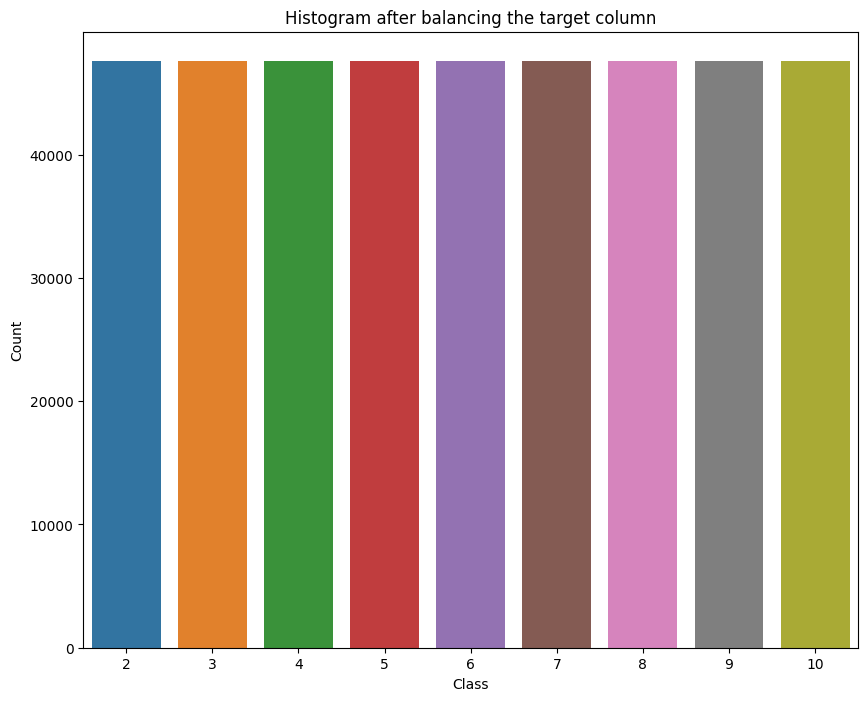

In [86]:

# Undersample to the size of the minority class
size = len(X[X["STRATUM"] == severity_counts.idxmin()].index)  # Minimum class count
balanced_dataframes = []  # List to hold the sampled DataFrames

for category in severity_counts.index:  # Loop through all categories
    subset = X[X["STRATUM"] == category]  # Filter category
    balanced_dataframes.append(subset.sample(size, random_state=42))  # Sample to minority size

# Concatenate all balanced subsets
balanced_df = pd.concat(balanced_dataframes, ignore_index=True)

# Update X with the balanced dataset
X = balanced_df

# Verify the new distribution
severity_counts = X["STRATUM"].value_counts()

# Visualize the balanced distribution
plt.figure(figsize=(10, 8))
plt.title("Histogram after balancing the target column")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [87]:
X.shape

(428238, 29)

#     One-hot encodes all columns with an object data type in the DataFrame. - Mitchell


In [88]:
import pandas as pd

def one_hot_encode_objects(df):
    # Identify columns with object data type
    object_columns = df.select_dtypes(include=['object']).columns
    
    # Apply one-hot encoding to these columns
    df_encoded = pd.get_dummies(df, columns=object_columns, drop_first=True)
    
    return df_encoded

# Example usage
encoded_df = one_hot_encode_objects(X)

# Inspect the resulting DataFrame
print(f"Shape before encoding: {X.shape}")
print(f"Shape after encoding: {encoded_df.shape}")

Shape before encoding: (428238, 29)
Shape after encoding: (428238, 183)


Drops columns that have a corresponding 'NAME' column in the DataFrame.
For example, drops 'STRATUM' if 'STRATUMNAME' exists.
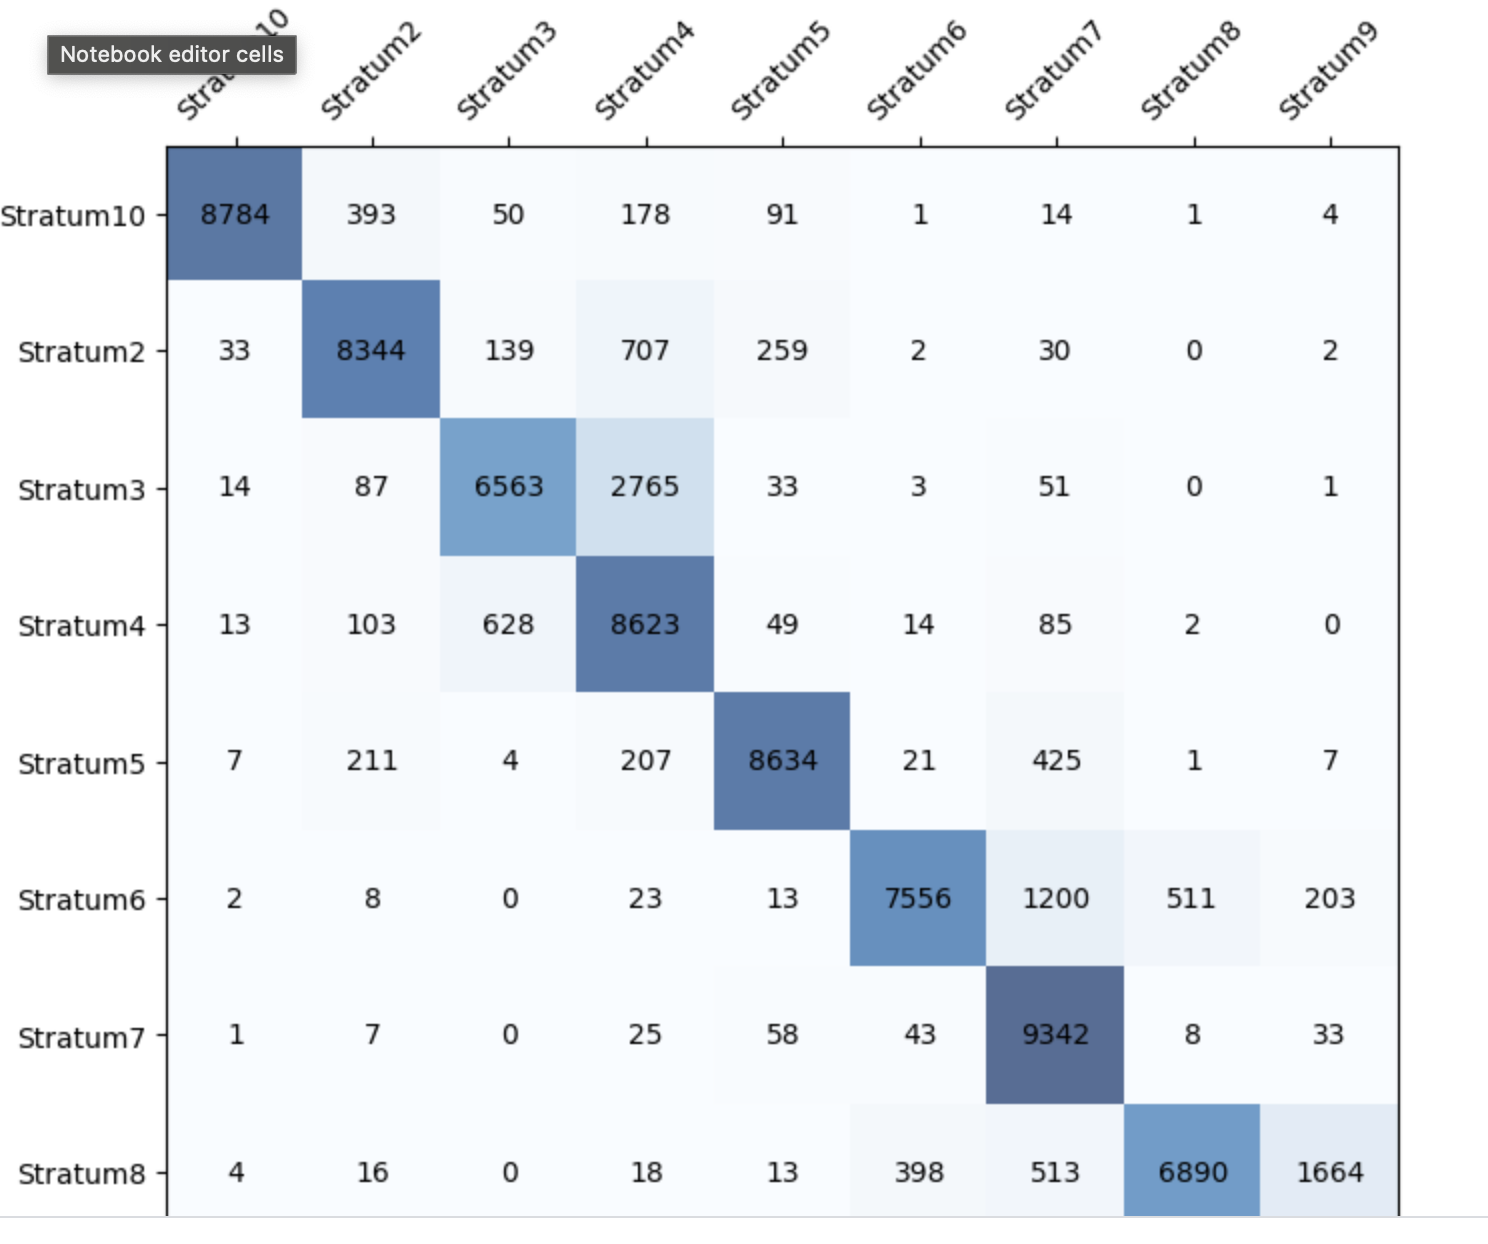

In [89]:
def drop_encoded_columns(df):

    # Identify columns with names
    name_columns = [col for col in df.columns if col.endswith('NAME')]
    
    # Identify corresponding encoded columns to drop
    encoded_columns_to_drop = [col[:-4] for col in name_columns if col[:-4] in df.columns]
    
    # Drop the identified columns
    df = df.drop(columns=encoded_columns_to_drop)
    
    return df

# Apply to your DataFrame
cleaned_df = drop_encoded_columns(encoded_df)

# Inspect the result
print(cleaned_df.columns)

Index(['CASENUM', 'STRATUM', 'VE_TOTAL', 'VE_FORMS', 'HARM_EV', 'LGT_COND',
       'WEATHER', 'MAXSEV_IM', 'WEIGHT', 'AGE',
       ...
       'BODY_TYPNAME_Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)',
       'BODY_TYPNAME_Van-Based Bus GVWR greater than 10,000 lbs.',
       'ROLLOVERNAME_Rollover, Tripped by Object/Vehicle',
       'ROLLOVERNAME_Rollover, Unknown Type',
       'ROLLOVERNAME_Rollover, Untripped', 'TOWEDNAME_Not Towed',
       'TOWEDNAME_Reported as Unknown',
       'TOWEDNAME_Towed But Not Due to Disabling Damage',
       'TOWEDNAME_Towed Due to Disabling Damage',
       'TOWEDNAME_Towed, Unknown Reason'],
      dtype='object', length=183)


In [90]:
cleaned_df.astype('float64')

,CASENUM,STRATUM,VE_TOTAL,VE_FORMS,HARM_EV,LGT_COND,WEATHER,MAXSEV_IM,WEIGHT,AGE,...,"BODY_TYPNAME_Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)","BODY_TYPNAME_Van-Based Bus GVWR greater than 10,000 lbs.","ROLLOVERNAME_Rollover, Tripped by Object/Vehicle","ROLLOVERNAME_Rollover, Unknown Type","ROLLOVERNAME_Rollover, Untripped",TOWEDNAME_Not Towed,TOWEDNAME_Reported as Unknown,TOWEDNAME_Towed But Not Due to Disabling Damage,TOWEDNAME_Towed Due to Disabling Damage,"TOWEDNAME_Towed, Unknown Reason"
0,2.019014e+11,9.0,2.0,2.0,12.0,1.0,1.0,0.0,162.104114,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.017012e+11,9.0,2.0,2.0,12.0,3.0,1.0,0.0,148.213050,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.020026e+11,9.0,2.0,2.0,12.0,1.0,1.0,0.0,95.702742,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2.018011e+11,9.0,2.0,2.0,12.0,1.0,1.0,0.0,167.972797,53.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2.020029e+11,9.0,3.0,3.0,12.0,5.0,1.0,0.0,116.089686,53.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428233,2.017003e+11,4.0,2.0,2.0,12.0,1.0,10.0,3.0,9.480328,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
428234,2.020027e+11,4.0,6.0,2.0,12.0,3.0,2.0,4.0,11.202201,998.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
428235,2.019022e+11,4.0,2.0,2.0,12.0,2.0,10.0,3.0,11.796265,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
428236,2.016001e+11,4.0,5.0,5.0,12.0,1.0,1.0,3.0,15.367317,29.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Normalize numeric values with Z-score Jomel

In [91]:
# List of numerical columns to normalize
numerical_cols = ['WEIGHT', 'VE_TOTAL', 'VE_FORMS', 'MAXSEV_IM', 'AGE', 'NUMINJ_IM', 'MAX_VSEV']

# Normalize each column using encode_numeric_zscore
for col in numerical_cols:
    encode_numeric_zscore(cleaned_df, col)

# Check the transformed DataFrame
print(cleaned_df[numerical_cols].head())

     WEIGHT  VE_TOTAL  VE_FORMS  MAXSEV_IM       AGE  NUMINJ_IM  MAX_VSEV
0  0.923642 -0.197413 -0.174614  -1.169099 -0.022897  -0.619661 -0.578235
1  0.742778 -0.197413 -0.174614  -1.169099 -0.225960  -0.619661 -0.578235
2  0.059085 -0.197413 -0.174614  -1.169099 -0.387488  -0.619661 -0.578235
3  1.000054 -0.197413 -0.174614  -1.169099 -0.165964  -0.619661 -0.578235
4  0.324526  0.714833  0.744205  -1.169099 -0.165964  -0.619661 -0.578235


In [92]:
# Separate features (X) and target (y)
X = cleaned_df.drop(columns=['STRATUM'])  # Drop target column from features
y = cleaned_df['STRATUM']                # Target column

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [93]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [94]:
X_train.shape

(342590, 182)

In [95]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

num_classes = len(encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [96]:
y_test.shape

(85648, 9)

In [97]:
y_train.shape

(342590, 9)

# Models

# FCNN - Mitchell Kouiyoth

In [98]:
model = Sequential()

# Input and hidden layers
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [99]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_model.keras", save_best_only=True)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=2
)


Epoch 1/100
10706/10706 - 24s - 2ms/step - accuracy: 0.7575 - loss: 0.6114 - val_accuracy: 0.8629 - val_loss: 0.4065
Epoch 2/100
10706/10706 - 17s - 2ms/step - accuracy: 0.8392 - loss: 0.4366 - val_accuracy: 0.8808 - val_loss: 0.3289
Epoch 3/100
10706/10706 - 17s - 2ms/step - accuracy: 0.8634 - loss: 0.3898 - val_accuracy: 0.9041 - val_loss: 0.2973
Epoch 4/100
10706/10706 - 16s - 2ms/step - accuracy: 0.8727 - loss: 0.3684 - val_accuracy: 0.9041 - val_loss: 0.2859
Epoch 5/100
10706/10706 - 16s - 2ms/step - accuracy: 0.8777 - loss: 0.3541 - val_accuracy: 0.9034 - val_loss: 0.2812
Epoch 6/100
10706/10706 - 16s - 2ms/step - accuracy: 0.8818 - loss: 0.3450 - val_accuracy: 0.9032 - val_loss: 0.2827
Epoch 7/100
10706/10706 - 17s - 2ms/step - accuracy: 0.8852 - loss: 0.3369 - val_accuracy: 0.9038 - val_loss: 0.2805
Epoch 8/100
10706/10706 - 16s - 2ms/step - accuracy: 0.8870 - loss: 0.3305 - val_accuracy: 0.9050 - val_loss: 0.2761
Epoch 9/100
10706/10706 - 17s - 2ms/step - accuracy: 0.8888 - lo

2677/2677 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

    Stratum2       0.99      0.94      0.96      9516
    Stratum3       0.95      0.90      0.93      9516
    Stratum4       0.93      0.80      0.86      9517
    Stratum5       0.77      0.94      0.85      9517
    Stratum6       0.97      0.96      0.97      9517
    Stratum7       0.96      0.84      0.90      9516
    Stratum8       0.86      0.98      0.92      9517
    Stratum9       0.93      0.87      0.90      9516
   Stratum10       0.90      0.97      0.93      9516

    accuracy                           0.91     85648
   macro avg       0.92      0.91      0.91     85648
weighted avg       0.92      0.91      0.91     85648



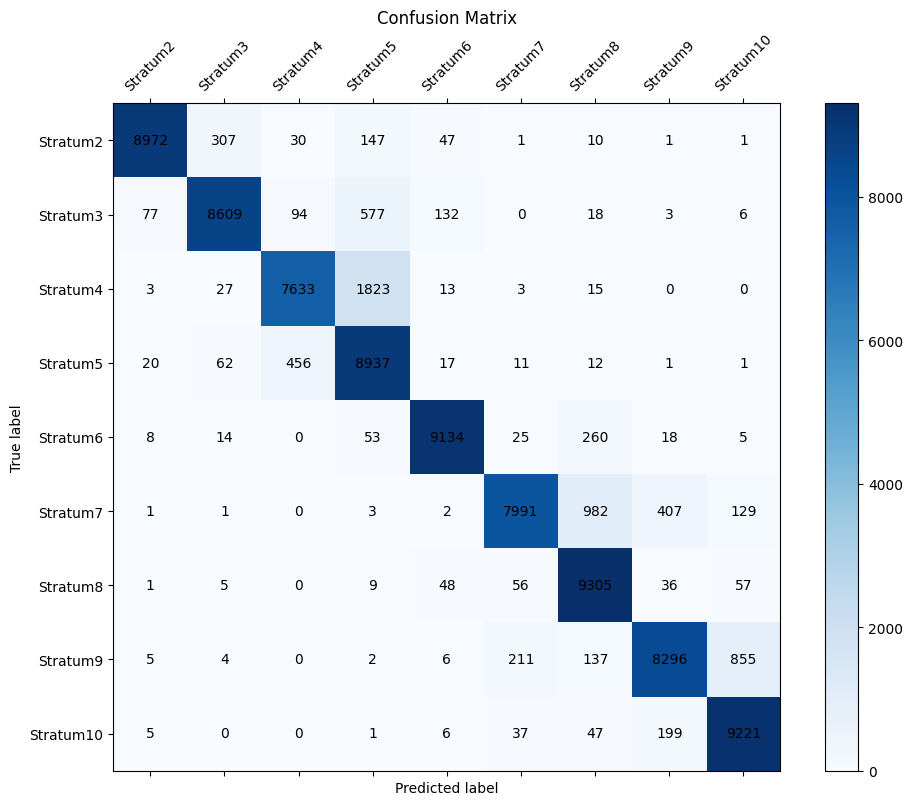

In [100]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

labels = [ "Stratum2", "Stratum3", "Stratum4", "Stratum5", 
          "Stratum6", "Stratum7", "Stratum8", "Stratum9","Stratum10"] 
print("Confusion Matrix:")



# Plot confusion matrix using the function
plot_confusion_matrix(cm, names=labels, title="Confusion Matrix")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


# FCNN - JOSE A

In [101]:
model = Sequential()

# Input and hidden layers
model.add(Dense(256, activation='tanh', input_dim=X_train.shape[1]))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_model.keras", save_best_only=True)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=2
)

Epoch 1/100
10706/10706 - 17s - 2ms/step - accuracy: 0.7071 - loss: 0.7617 - val_accuracy: 0.8091 - val_loss: 0.5031
Epoch 2/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8084 - loss: 0.4952 - val_accuracy: 0.8450 - val_loss: 0.4381
Epoch 3/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8367 - loss: 0.4376 - val_accuracy: 0.8364 - val_loss: 0.4173
Epoch 4/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8522 - loss: 0.4001 - val_accuracy: 0.8630 - val_loss: 0.3912
Epoch 5/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8653 - loss: 0.3699 - val_accuracy: 0.8693 - val_loss: 0.3487
Epoch 6/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8732 - loss: 0.3502 - val_accuracy: 0.8903 - val_loss: 0.3183
Epoch 7/100
10706/10706 - 15s - 1ms/step - accuracy: 0.8794 - loss: 0.3341 - val_accuracy: 0.8960 - val_loss: 0.3019
Epoch 8/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8841 - loss: 0.3225 - val_accuracy: 0.8923 - val_loss: 0.2987
Epoch 9/100
10706/10706 - 16s - 1ms/step - accuracy: 0.8891 - lo

2677/2677 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

    Stratum2       0.99      0.94      0.96      9516
    Stratum3       0.95      0.90      0.92      9516
    Stratum4       0.96      0.76      0.85      9517
    Stratum5       0.75      0.96      0.84      9517
    Stratum6       0.97      0.97      0.97      9517
    Stratum7       0.96      0.86      0.91      9516
    Stratum8       0.88      0.98      0.93      9517
    Stratum9       0.93      0.89      0.90      9516
   Stratum10       0.91      0.96      0.94      9516

    accuracy                           0.91     85648
   macro avg       0.92      0.91      0.91     85648
weighted avg       0.92      0.91      0.91     85648



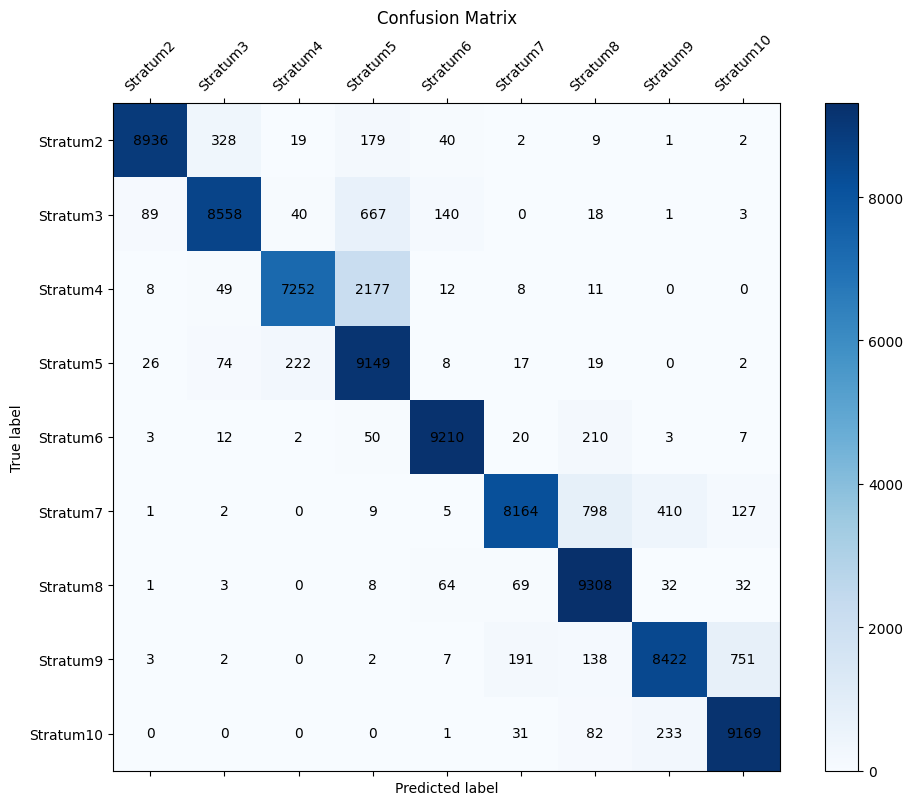

In [103]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

labels = [ "Stratum2", "Stratum3", "Stratum4", "Stratum5", 
          "Stratum6", "Stratum7", "Stratum8", "Stratum9","Stratum10"] 
print("Confusion Matrix:")



# Plot confusion matrix using the function
plot_confusion_matrix(cm, names=labels, title="Confusion Matrix")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


# 2D CNN- Jose v

In [104]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (342590, 182)


In [105]:
X_cnn = cleaned_df.drop(columns=['STRATUM'])  # Drop target column from features
y_cnn = cleaned_df['STRATUM']  
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_cnn)

 

In [106]:
# Reshape X_train and X_test for CNN
X_train_cnn = X_train.reshape(-1, 14, 13, 1)  # Adjust dimensions as per your input
X_test_cnn = X_test.reshape(-1, 14, 13, 1)
print("before X_train_cnn:", X_train.shape)
print("before X_test_cnn:", X_test.shape)
print("Reshaped X_train_cnn:", X_train_cnn.shape)
print("Reshaped X_test_cnn:", X_test_cnn.shape)


before X_train_cnn: (342590, 182)
before X_test_cnn: (85648, 182)
Reshaped X_train_cnn: (342590, 14, 13, 1)
Reshaped X_test_cnn: (85648, 14, 13, 1)


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Ensure correct data types
X_train_cnn = X_train_cnn.astype(np.float32)
X_test_cnn = X_test_cnn.astype(np.float32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

print("X_train_cnn shape:", X_train_cnn.shape)
print("y_train shape:", y_train.shape)

X_train_cnn shape: (342590, 14, 13, 1)
y_train shape: (342590,)


In [108]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input


# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(14, 13, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Adjust the output size to match the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (e.g., validation loss)
    min_delta=1e-3,
    patience=3,             # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored metric
)


# Train the model
history = model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test),callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.6580 - loss: 0.8865 - val_accuracy: 0.8576 - val_loss: 0.4271
Epoch 2/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8642 - loss: 0.4071 - val_accuracy: 0.8843 - val_loss: 0.3479
Epoch 3/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8823 - loss: 0.3484 - val_accuracy: 0.8771 - val_loss: 0.3524
Epoch 4/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8912 - loss: 0.3215 - val_accuracy: 0.8896 - val_loss: 0.3214
Epoch 5/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8943 - loss: 0.3091 - val_accuracy: 0.8978 - val_loss: 0.2991
Epoch 6/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8982 - loss: 0.2973 - val_accuracy: 0.8944 - val_loss: 0.3050
Epoch 7/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9007 - loss: 0.2874 - val_accuracy: 0.9008 - val_loss: 0.2876
Epoch 8/10
10706/10706 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 

2677/2677 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Final accuracy: 0.90
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

    Stratum2       0.98      0.93      0.96      9516
    Stratum3       0.88      0.95      0.91      9516
    Stratum4       0.95      0.78      0.86      9517
    Stratum5       0.79      0.90      0.84      9517
    Stratum6       0.97      0.96      0.96      9517
    Stratum7       0.91      0.86      0.88      9516
    Stratum8       0.87      0.96      0.91      9517
    Stratum9       0.90      0.87      0.88      9516
   Stratum10       0.92      0.93      0.92      9516

    accuracy                           0.90     85648
   macro avg       0.91      0.90      0.90     85648
weighted avg       0.91      0.90      0.90     85648



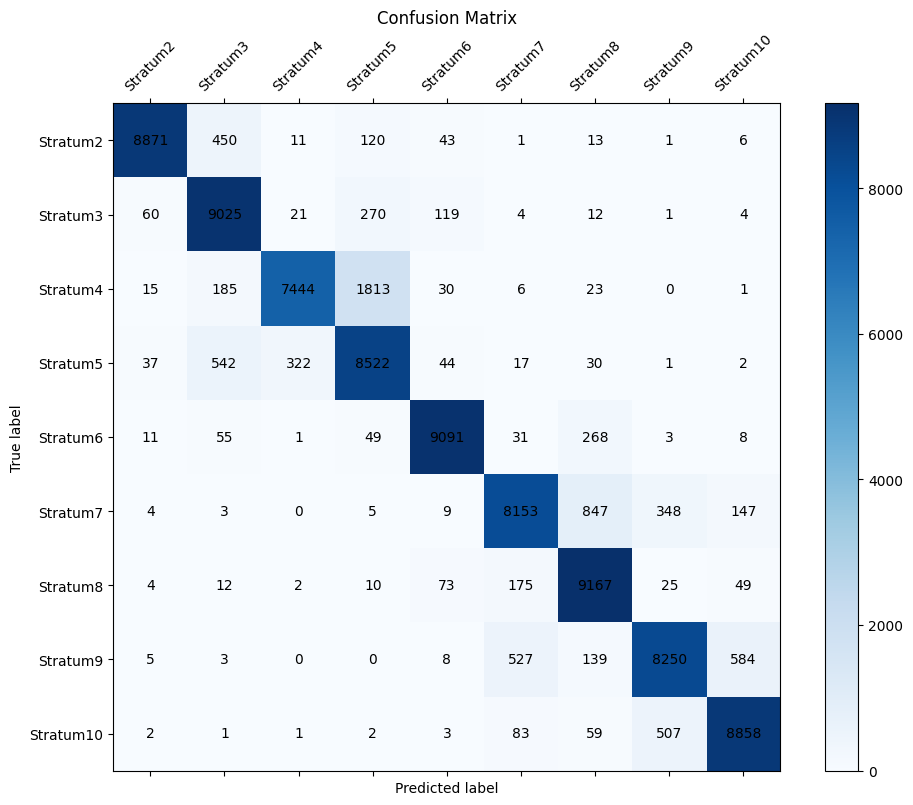

In [109]:
# Predict using the model
pred = model.predict(X_test_cnn)  # Assuming X_test is the input data for testing
pred = np.argmax(pred, axis=1)  # Convert predictions to class labels

# Convert y_test to class labels if necessary
if len(y_test.shape) > 1:  # Check if y_test is one-hot encoded
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test  # Already in class label format

# Accuracy
score = accuracy_score(y_true, pred)
print(f"Final accuracy: {score:.2f}")

# Generate the confusion matrix
cm = confusion_matrix(y_true, pred)
labels = [ "Stratum2", "Stratum3", "Stratum4", "Stratum5", 
          "Stratum6", "Stratum7", "Stratum8", "Stratum9","Stratum10"] 
print("Confusion Matrix:")



# Plot confusion matrix using the function
plot_confusion_matrix(cm, names=labels, title="Confusion Matrix")
print("\nClassification Report:")
print(classification_report(y_true, pred, target_names=labels))


In [110]:
# df_y = pd.DataFrame(y_test, columns=['truth'])  # True star ratings
# df_pred = pd.DataFrame(pred, columns=['predicted'])    # Predicted star ratings

# # Concatenate both into one DataFrame for comparison
# result = pd.concat([df_y, df_pred], axis=1)


# for i in range (5):
#     print("{}.  Truth: {}. Predicted : {}".format(i+1,y_test[i],pred[i]))


# 1D CNN without transfer learning

In [111]:
# Separate features (X) and target (y)
X = cleaned_df.drop(columns=['STRATUM']).values  # Convert to NumPy array
y = cleaned_df['STRATUM']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Reshape X for 1D CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


# Ensure data types are correct
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

# Check for NaNs or infinite values
assert not np.isnan(X_train).any(), "NaNs found in X_train"
assert not np.isinf(X_train).any(), "Infinite values found in X_train"
assert not np.isnan(y_train).any(), "NaNs found in y_train"
assert not np.isinf(y_train).any(), "Infinite values found in y_train"


In [112]:
# Build the 1D CNN model
model = Sequential()

# Use Input layer to specify input shape
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Output layer

# Compile the model using sparse_categorical_crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=3, restore_best_weights=True)

In [1]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


NameError: name 'model' is not defined

In [ ]:
print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("y_train shape:", y_train.shape, "dtype:", y_train.dtype)


In [ ]:
# Predict using the model
pred = model.predict(X_test)  # Assuming X_test is the input data for testing
pred = np.argmax(pred, axis=1)  # Convert predictions to class labels

# Convert y_test to class labels if necessary
if len(y_test.shape) > 1:  # Check if y_test is one-hot encoded
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test  # Already in class label format

# Accuracy
score = accuracy_score(y_true, pred)
print(f"Final accuracy: {score:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, pred)
print("Confusion Matrix:")

labels = [ "Stratum2", "Stratum3", "Stratum4", "Stratum5", 
          "Stratum6", "Stratum7", "Stratum8", "Stratum9","Stratum10"]  # Replace with actual labels

# Plot confusion matrix using the function
plot_confusion_matrix(cm, names=labels, title="Confusion Matrix")
print("\nClassification Report:")
print(classification_report(y_true, pred, target_names=labels))

# Extra feature Transformer - Jose V

In [ ]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# One-Hot Encode categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

# Handle missing values
df.fillna(0, inplace=True)

# Placeholder target column for demonstration
target = 'STRATUM'

# Split data into features and target
X, y = to_xy(df, target)  # Using the helper function in the notebook
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters for the Transformer
seq_length = X_train.shape[1]  # Number of features as sequence length
num_heads = 4 
embed_dim = 64  
ff_dim = 128  
dropout_rate = 0.1

# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.0):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

# Model definition
inputs = Input(shape=(seq_length,))
x = Embedding(input_dim=20000, output_dim=embed_dim)(inputs)  # Adjust `input_dim` as needed
x = transformer_encoder(x, head_size=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout_rate)
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(y_train.shape[1], activation="softmax")(x)  # Adjust activation for classification or regression

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=5e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    ]
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [ ]:
# Predict using the model
pred = model.predict(X_test)  # Assuming X_test is the input data for testing
pred = np.argmax(pred, axis=1)  # Convert predictions to class labels

# Convert y_test to class labels if necessary
if len(y_test.shape) > 1:  # Check if y_test is one-hot encoded
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test  # Already in class label format

# Accuracy
score = accuracy_score(y_true, pred)
print(f"Final accuracy: {score:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, pred)
labels = [ "Stratum2", "Stratum3", "Stratum4", "Stratum5", 
          "Stratum6", "Stratum7", "Stratum8", "Stratum9","Stratum10"] 
print("Confusion Matrix:")



# Plot confusion matrix using the function
plot_confusion_matrix(cm, names=labels, title="Confusion Matrix")
print("\nClassification Report:")
print(classification_report(y_true, pred, target_names=labels))
